In this tutorial, we'll use the following techniques to clasifier on the dataset to achieve a better accuracy:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

In [163]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [164]:
# Look into the data directory
data_dir = r'C:\Users\Glodaris\Downloads\dataset'
classes = os.listdir(data_dir)
print(classes)

['person_without_papersheet', 'person_with_papersheet']


We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use %10 of dataset for validation**: we will be setting aside a fraction of 10% of our training dataset for validation

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will resize the images by 224 x 224 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://raw.githubusercontent.com/okoliechykwuka/portfolio/master/download.png)


**stats** Is the mean and stddev of Imagenet dataset. Reason: The distribution of inputs to a network is desired to have a fixed mean and variance, to avoid covariate shift (see batch normalization paper). Usually mean = zero and stdev =1 (of standard normal distribution) is considered. So we need to normalize the data with mean and stdev of the space of input to the network, i.e., natural image space. As Imagenet is a huge dataset with 1000 classes, it is desirable to consider its mean and stddev as a good approximate of natural image space, as compared to finding it from smaller datasets, like ours  in hand. Therefore, for smaller datasets, better to use Imagenet statistics to model the input distribution. Further reading: https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer

In [165]:
# Data transforms (normalization & data augmentation)
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transforms = transforms.Compose([
                         transforms.RandomHorizontalFlip(), 
                         transforms.Resize([int(224), int(224)]),
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#                         transforms.RandomRotation(degrees = (90,90)),
#                         transforms.RandomRotation(degrees = (180,180)),
#                         transforms.RandomRotation(degrees = (270,270)),
#                         transforms.RandomVerticalFlip(p=1),
                        #transforms.AutoAugment(),
                          
                         transforms.ToTensor(),
                         transforms.Normalize(*stats,inplace=True),
                         ]) 


In [4]:
# PyTorch datasets
dataset = ImageFolder(data_dir, transforms)

In [5]:
img, label = dataset[0]
print(img.shape, label)
print(type(img))

torch.Size([3, 224, 224]) 0
<class 'torch.Tensor'>


The list of classes is stored in the .classes property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

Let's look at a sample element from the dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 224x224 px color images with 3 channels (RGB), each image tensor has the shape (3, 224, 224).

In [6]:
print(dataset.classes)

['person_with_papersheet', 'person_without_papersheet']


We can view the image using matplotlib, but we need to change the tensor dimensions to (224,224,3). Let's create a helper function to display an image and its label.

In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Let's look at a couple of images from the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  person_with_papersheet (0)


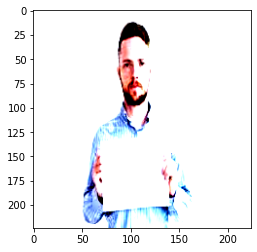

In [8]:
show_example(*dataset[0])

### Training and Validation Datasets


**Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.


**Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.

**Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (244 images) of the training set to be used as the validation set. We'll use the random_split helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [9]:
random_seed = 42
torch.manual_seed(random_seed);

In [10]:
val_size = 254
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2290, 254)

In [11]:
batch_size=16

In [12]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True,drop_last=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True,drop_last=True)

We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [13]:
# def denormalize(images, means, stds):
#     means = torch.tensor(means).reshape(1, 3, 1, 1)
#     stds = torch.tensor(stds).reshape(1, 3, 1, 1)
#     return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        print(images.shape)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = images#denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

torch.Size([16, 3, 224, 224])


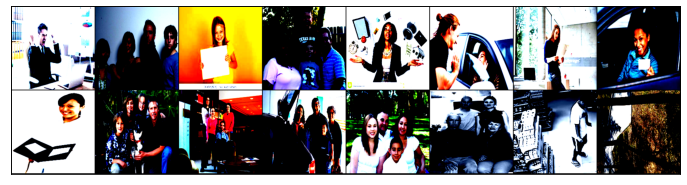

In [14]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)



> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [15]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    print(output.shape)
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [16]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

torch.Size([3, 3])


tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

Refer to [Sylvian's post](https://sgugger.github.io/convolution-in-depth.html) for an explanation of `kernel_size`, `stride` and `padding`. 

In [19]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([16, 3, 224, 224])
out.shape: torch.Size([16, 8, 112, 112])


## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in a [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [21]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model  is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simple Residual block:

In [23]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [24]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([16, 3, 224, 224])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512*49, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [27]:
model = to_device(ResNet9(3, 2), device)

In [28]:
def model_summary(model):
    print("model_summary")
    print()
    print("Layer_name"+"\t"*7+"Number of Parameters")
    print("="*100)
    model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
    layer_name = [child for child in model.children()]
    j = 0
    total_params = 0
    print("\t"*10)
    for i in layer_name:
        param = 0
        try:
            bias = (i.bias is not None)
        except:
            bias = False  
        if not bias:
            param =model_parameters[j].numel()+model_parameters[j+1].numel()
            j = j+2
        else:
            param =model_parameters[j].numel()
            j = j+1
        print(str(i)+"\t"*3+str(param))
        total_params+=param
    print("="*100)
    print(f"Total Params:{total_params}")       

model_summary(model)

model_summary

Layer_name							Number of Parameters
										
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)			1792
Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)			128
Sequential(
  (0): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=Tr

Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

* **Learning rate scheduling:** Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay:** We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping:** Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

Let's define a fit_one_cycle function to incorporate these changes. We'll also record the learning rate used for each batch.

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6939697861671448, 'val_acc': 0.5535714030265808}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [31]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [32]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00104, train_loss: 1.9729, val_loss: 2.1512, val_acc: 0.7366
Epoch [1], last_lr: 0.00279, train_loss: 2.3708, val_loss: 7.8041, val_acc: 0.6116
Epoch [2], last_lr: 0.00519, train_loss: 3.1611, val_loss: 4.3459, val_acc: 0.6161
Epoch [3], last_lr: 0.00759, train_loss: 2.8996, val_loss: 0.7275, val_acc: 0.8304
Epoch [4], last_lr: 0.00936, train_loss: 1.2644, val_loss: 0.3819, val_acc: 0.8571
Epoch [5], last_lr: 0.01000, train_loss: 0.5551, val_loss: 0.3807, val_acc: 0.8527
Epoch [6], last_lr: 0.00987, train_loss: 0.4503, val_loss: 0.3145, val_acc: 0.8438
Epoch [7], last_lr: 0.00950, train_loss: 0.3880, val_loss: 0.3458, val_acc: 0.8438
Epoch [8], last_lr: 0.00891, train_loss: 0.3743, val_loss: 0.3386, val_acc: 0.8348
Epoch [9], last_lr: 0.00812, train_loss: 0.3940, val_loss: 0.4596, val_acc: 0.7857
Epoch [10], last_lr: 0.00717, train_loss: 0.4947, val_loss: 0.3716, val_acc: 0.8304
Epoch [11], last_lr: 0.00611, train_loss: 0.3569, val_loss: 0.3339, val_acc: 0.8616
Ep

## Saving and loading the model


Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [34]:
torch.save(model.state_dict(), 'paper-sheet.pth')

In [35]:
load_model = ResNet9(3,2)

In [36]:
load_model.load_state_dict(torch.load('paper-sheet.pth'))
# load_model.state_dict()

<All keys matched successfully>

In [37]:
# load_model

In [39]:
train_time='24:18'

Our model trained to over 87% accuracy in under 24 minutes! Try playing around with the data augmentations, network architecture & hyperparameters to achive the following results:


Let's plot the valdation set accuracies to study how the model improves over time.

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

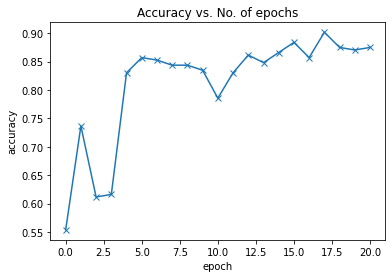

In [41]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

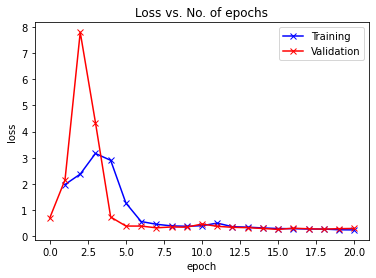

In [43]:
plot_losses(history)

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.

In [148]:
def predict_val(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.dataset.classes[preds[0].item()]

Label: person_with_papersheet , Predicted: person_with_papersheet


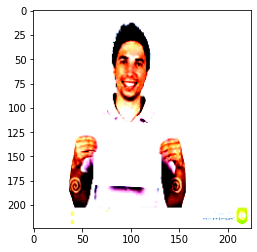

In [149]:
img, label = val_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.dataset.classes[label], ', Predicted:', predict_val(img, model))

In [181]:
from PIL import Image
from IPython.display import display
image = r'C:\Users\Glodaris\OneDrive\Desktop\test_11.jpg'

In [182]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means


def predict_image(image):

    with Image.open(path) as img_file: 
        display(img_file)
        tensor_img = transforms(img_file)
        xb = to_device(tensor_img.unsqueeze(0), device)
        yb = model(xb)
        # Pick index with highest probability
        _, preds  = torch.max(yb, dim=1)
    return train_ds.dataset.classes[preds[0].item()]



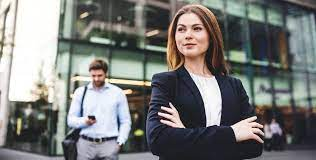

'person_without_papersheet'

In [183]:
predict_image(image)